In [46]:
import cv2
import random
import time, datetime
import yaml
import ast, bisect
import csv
import pathlib, sys, os

_pth = str(pathlib.Path("test.ipynb").absolute())
for i in range(2):
    (_pth, _) = os.path.split(_pth)
sys.path.insert(0, _pth)  # I just made sure that the root of the project (ContrastiveTeamO) is in the path where Python
# looks for packages in order to import from files that require going several levels up from the directory where this
# script is. Unfortunately, by default Python doesn't allow imports from above the current file directory.


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import transformations.transforms as transforms2

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import torchvision

from torchvision.datasets import CIFAR10

import torch.backends.cudnn as cudnn

# CUDA info
has_cuda = torch.cuda.is_available()
cudnn.benchmark = True
sd = 0

# Set random seed
torch.manual_seed(sd)
np.random.seed(sd)

root = '/home/campus/oberman-lab/data'


class SimCLRDataTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj


class TensorSimCLRDataTransform:
    """Assumes it is called on tensors, unlike its analogue SimCLRDataTransform. DO NOT pass a transforms.Compose()
    object in the constructor of this class. Pass directly the transformations as separate arguments."""

    def __init__(self, *argv):
        self.transforms = argv

    def __call__(self, sample):
        for transform in self.transforms:
            sample = transform(sample)
        return sample


def get_color_distortion(s=1.0):
    # transforms a PIL image
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([
        rnd_color_jitter,
        rnd_gray])
    return color_distort

data_augment = TensorSimCLRDataTransform(transforms.RandomResizedCrop(size=32),
                                         transforms.RandomHorizontalFlip(),
                                         get_color_distortion(
                                             s=1.0))  # This should be called on original samples of x
ds_train = CIFAR10(root, download=True, train=True, transform=transforms.ToTensor())

num_train = len(ds_train)
indices = list(range(num_train))
np.random.shuffle(indices)

valid_size = 0.05
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(ds_train, batch_size=1,
                          num_workers=4, drop_last=True, shuffle=False)
valid_loader = DataLoader(ds_train, batch_size=1,
                          num_workers=4, drop_last=True)

def to_grayscale(img):
    new_img = torch.mean(img, dim=1, keepdim=True)
    new_img = torch.cat((new_img, new_img, new_img), dim=1)
    return new_img



gray_image = None
original = None

for (x, y) in train_loader:
    gray = to_grayscale(x)
    print(x.shape)
    print("\n")
    print(gray.shape)
    gray = gray.squeeze()
    gray = gray.permute(1, 2, 0)
    np_img = gray.detach().cpu().numpy()

    original = x.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    print(np_img.shape)
    print(type(np_img))
    gray_image = np_img
    break


Files already downloaded and verified
torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])
(32, 32, 3)
<class 'numpy.ndarray'>


Visualizing only the grayscale transform:

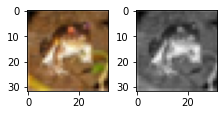

In [47]:
# plt.imshow(gray_image)
# plt.show()
# plt.imshow(original)

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(3,2))
# for i, ax in enumerate(axs.flat):
#   ax.imshow(original)
axs = axs.flat

axs[0].imshow(original)
axs[1].imshow(gray_image)

plt.show()

Visualizing `SimCLRDataTransform`:


In [48]:
class SimCLRDataTransform:
    """Produces the 2 data augmentations for each image. To be called on a batch of images (Tensor of shape BxCxWxH)"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        xis = x.clone()
        xjs = x.clone()
        for i in range(x.shape[0]):
            xis[i] = self.transform(xis[i])
            xjs[i] = self.transform(xjs[i])
        return xis, xjs


class RandomGrayscale:
    """Converts ONE tensor image to grayscale with probability p and outputs a Tensor image"""

    def __init__(self, p=0.1):
        self.p = p

    def to_grayscale(self, img):
        new_img = torch.mean(img, dim=0, keepdim=True)
        new_img = torch.cat((new_img, new_img, new_img), dim=0)
        return new_img

    def __call__(self, img):
        if random.random() < self.p:
            gray_img = self.to_grayscale(img)
            return gray_img
        return img


def get_color_distortion(s=1.0):
    # transforms a Tensor image
    # s is the strength of color distortion.
    color_jitter = transforms2.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = transforms2.RandomApply([color_jitter], p=0.8)
    rnd_gray = RandomGrayscale(p=0.2)
    color_distort = transforms2.Compose([
        rnd_color_jitter,
        rnd_gray])
    return color_distort

data_transforms = transforms2.Compose([transforms2.RandomResizedCrop(size=32),
                                      transforms2.RandomHorizontalFlip(),
                                      get_color_distortion(s=1.0)])

data_augment = SimCLRDataTransform(data_transforms)

ds_train2 = CIFAR10(root, download=True, train=True, transform=transforms2.ToTensor())

train_loader = DataLoader(ds_train2, batch_size=1,
                          num_workers=4, drop_last=True, shuffle=False)
valid_loader = DataLoader(ds_train2, batch_size=1,
                          num_workers=4, drop_last=True)


for (x, y) in train_loader:
    break

Files already downloaded and verified


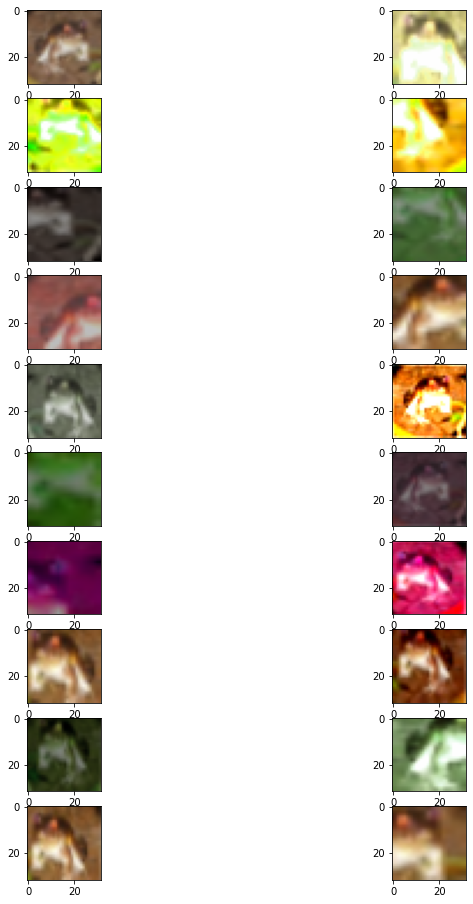

In [53]:
fix, axs = plt.subplots(nrows=10, ncols=2, constrained_layout=False, figsize=(12, 16))
for i, ax in enumerate(axs.flat):
    xi, _ = data_augment(x)
    img = xi.squeeze()
    img = img.permute(1, 2, 0)
    img = img.detach().cpu().numpy()
    ax.imshow(img)
plt.show()
